# **Alex_CIS 545_finalProject**

## Goal


Find out the role of the time of each review

**Note:** you can check each step on the table of contents in side menu



In [0]:
# install stuff
%%capture
!pip install -U gensim
!pip install urllib2

In [0]:
# check gensim version
import gensim
gensim.__version__

'3.8.1'

In [0]:
# import stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from datetime import *
from operator import itemgetter

import math
import json
import time
import csv

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [0]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

In [0]:
#convert rating for preparing plot
star=y.tolist()

# Step 1： Threw Back to HW4

Since this project is the continum of HW4, it might be great to start with the step (tSNE) left behind. Just to fresh the memory:  In homework4, we were mostly trying to bridge gap between review content and rating by using Gensim to evaluate the importance of a word in a single review through. We successfully finding the best number of cluster, but we haven't find anything related to rating.

## Step1.1: Function

In [0]:
#convert time no norm
def convert_times(reviews_times):
  time_list=[]
  for items in reviews_times:
    time_list.append(datetime.fromtimestamp(items))#normalize time
  newtime=pd.Series(time_list)
  return newtime

In [0]:
#lookupfunction
#I decided to use lookup_docs, because later it'll be used in t-NSE
def lookup_docs(corpus, indices):
    list_temp = pd.DataFrame(indices).drop_duplicates()
    list_temp.columns = ['indices']
    list_num = list_temp.sort_values(by=['indices']).reset_index(drop=True)   
    i = 0
    j = 0
    result = []
    for document in corpus:
      if j == list_num.indices[i]:
        result.append(document)
        i= i+1
      if i == len(list_num):
        break
      j = j+1
    return result

In [0]:
#translate function
#These function is to translate BOW into human language. Noted: the order of revies is not the same as original in Amazon review
def translate_review(review, reviews_dict):
  s = ""
  for item in review:
    for i in range(int(item[1])):
      s = s+" "+reviews_dict[item[0]]

  return s.strip()

In [0]:
#nearest_neightbor function
#The function can give you the k dots that closet to item.
def k_nearest_neighbors(X_proj, mask, item, k):

  normalized_item_f=np.linalg.norm(item)
  normalized_item=item/normalized_item_f
  list_431_1=[]#接cos 
  for i,stuff in enumerate(X_proj):
    normalized_stuff_f=np.linalg.norm(stuff)
    normalized_stuff=stuff/normalized_stuff_f
    if mask[i]==True and normalized_stuff_f>=0.01 :
      cos_item=np.dot(stuff,item)/normalized_stuff_f*normalized_item_f  
      list_431_1.append((i,cos_item)) 
  list_431_1.sort(key = itemgetter(1), reverse = True)

  result=[]
  for (a,thing) in list_431_1[:k]:
    result.append(a)
  return result

In [0]:
#densify function
#To get the term-document matrix, i need to convert this matrix to its dense form.
def densify(sparse, columns):
  #create a numpy array with specific shape and size based on givn sparse and column
  resultMatrix=np.zeros((len(sparse),columns))
  for idx,val in enumerate(sparse): 
    for (i,num) in val:
      if i<=columns:
        resultMatrix[idx][i]=num
  return resultMatrix

In [0]:
#get_exemplars
#corresponds to a closest neighbor to a cluster center.
def get_exemplars(X_proj, km, n_exemplars):
  alist = []
  
  for i,center in enumerate(km.cluster_centers_):
    mask = (km.labels_ == i)
    alist_temp = k_nearest_neighbors(X_proj, mask, center, n_exemplars)
    alist.append(alist_temp)
  return alist

In [0]:
#get review_tfidf
def make_tfidf(reviews_bow):
  model = TfidfModel(reviews_bow,normalize=True)
  vector = model[reviews_bow]
  return vector
reviews_tfidf = make_tfidf(reviews_bow)

#X project
cutoff = 40
LsiModel_5 = LsiModel(reviews_tfidf, id2word=reviews_dict, num_topics = cutoff)
X = densify(LsiModel_5[reviews_tfidf], cutoff)

In [0]:
km = KMeans(n_clusters=35, init='k-means++', n_init=30, max_iter=10, 
            tol=1e-4, random_state=1911, n_jobs=1)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
       n_clusters=35, n_init=30, n_jobs=1, precompute_distances='auto',
       random_state=1911, tol=0.0001, verbose=0)

In [0]:
#1 tsn
exemplar_indices = get_exemplars(X, km, 30)
exemplars = lookup_docs(reviews_tfidf, sum(exemplar_indices, []))
for_tsne = densify(exemplars, len(reviews_dict))
for_tsne.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


(1050, 18716)

In [0]:
exemplars = lookup_docs(reviews_bow, sum(exemplar_indices, []))
for exemplar in exemplars:
    print(translate_review(exemplar, reviews_dict))

also better just just money much took tri wast will clean clean filter filter full put use water water water decid horribl run now work get month take take got got like probabl second thing thing year even contain contain deal say throw throw minut minut power power sure expens half lot lot easi less less addit conveni truli concern nois whisper whisper whisper whisper qualiti shock away.th bacteria bio-wheel bio-wheel bio-wheel biowheel chore churn coloni constant far flow goodby grow maintain marineland marineland marineland noisi okay pain pain shack steadi tire without
away came good mix tri regular sinc recommend go around year even thought never eat food food food dri look servic sure paw walk seem feed ingredi list chicken blue bowl serious three rescu snif buffalo demand elabor expert felin hairbal halo halo highli hunch imit looov morsel necessarili oldest particularli perform picki separ situat spot' spot' spot' stew stew true
favorit just just took dog dog know put horribl g

In [0]:
#2 tsn
tsne_model_2d = TSNE(perplexity=20, n_components=2, init='pca', n_iter=3500, random_state=1911)
embeddings_2d = tsne_model_2d.fit_transform(for_tsne)
embeddings_2d.shape

(1050, 2)

In [0]:
#3 tsn color 
def tsne_plot(embedding_clusters, a):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(embedding_clusters)))
    for embeddings, color in zip(embedding_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color]*len(x), alpha=a)
    plt.show()

# answer 5.3.1
# TODO: group the t-SNE embeddings by cluster membership
embeddings = []
i = 0
tempx = []
# tempy = []
for item in embeddings_2d:
  tempx.append(item.tolist())
  # tempy.append(item.tolist()[1])
  i = i+1
  if i ==30:
    embeddings.append(tempx)
    i = 0
    tempx = []
    tempy = []
embeddings = np.array(embeddings)


## Step1.2: t-SNE
I successfully finding the best number of cluster, and assign different color for clusters

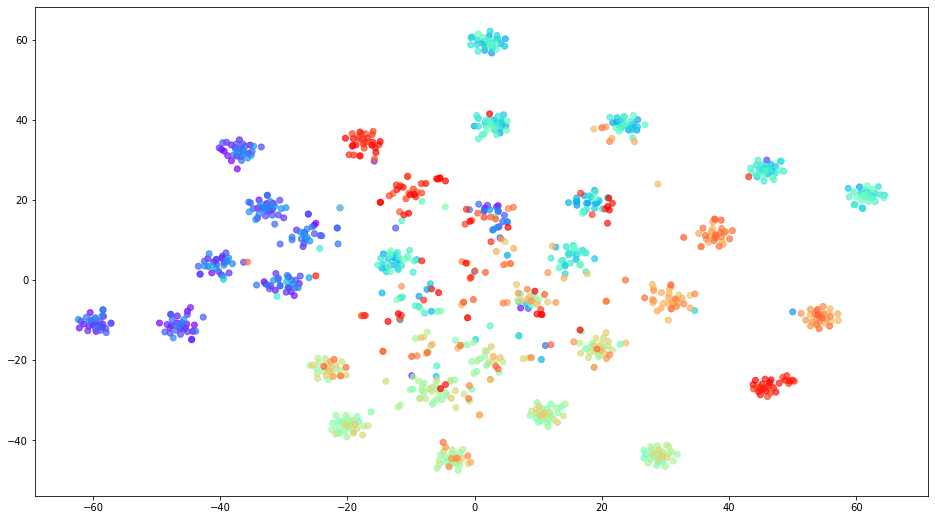

In [0]:
tsne_plot(embeddings, 0.7)

In [0]:
embeddings = [[],[],[],[],[]]
temp = [[],[],[],[],[]]
for want,use in zip(embeddings_2d,sum(exemplar_indices, [])):
  star = y[use]-1
  # print(y[use])
  temp[star].append(want.tolist())
for i in range(5):
  embeddings[i] = np.array(temp[i])

# embeddings = np.array(embeddings)
embeddings[1].shape

(263, 2)

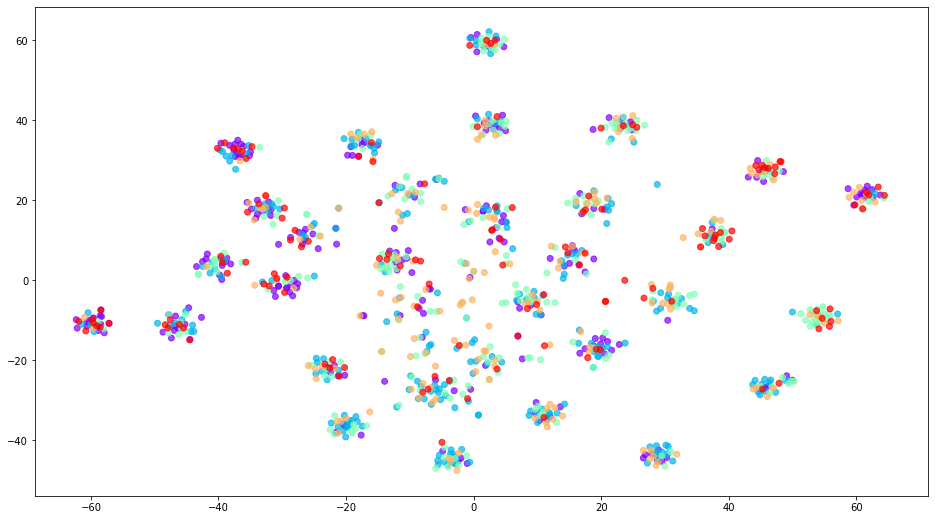

In [0]:
tsne_plot(embeddings, 0.7)

**Quick Insights for 1.2:** 
keeping  these cluster, I group the reviews by star rating. Even if in HW4. Instructor mentind there is no feasible pattern in current clustering, but if take closer look at the rating distribution. We did can find the red dot did cluster in the left button. Maybe the clustering is not perfect for predicting rating, but for me it says this rating have something to do with rating

## Step 1.3 Time's Role in Cluster
I'm interested in what contribution that time might create to the clustering in HW4. Another reason would be: it is something we haven't fully look at in HW

### Step 1.3.1 Month

I started with Unit of "month", because it is a big period for human behavior, product production. and it contains a lots of events (such as festival and holiday) that have really high opportunity to trigger people's desire for purchasing.

In [0]:
converted_times = convert_times(reviews_times)
print("converted_times is a", type(converted_times))

converted_times is a <class 'pandas.core.series.Series'>


In [0]:
#pull out the month of each rating, this might take 5 minutes
time_onlym=[]
for item in converted_times:
    time_onlym.append(int(item.strftime("%m")))
    time_onlymonth=np.asarray(time_onlym)

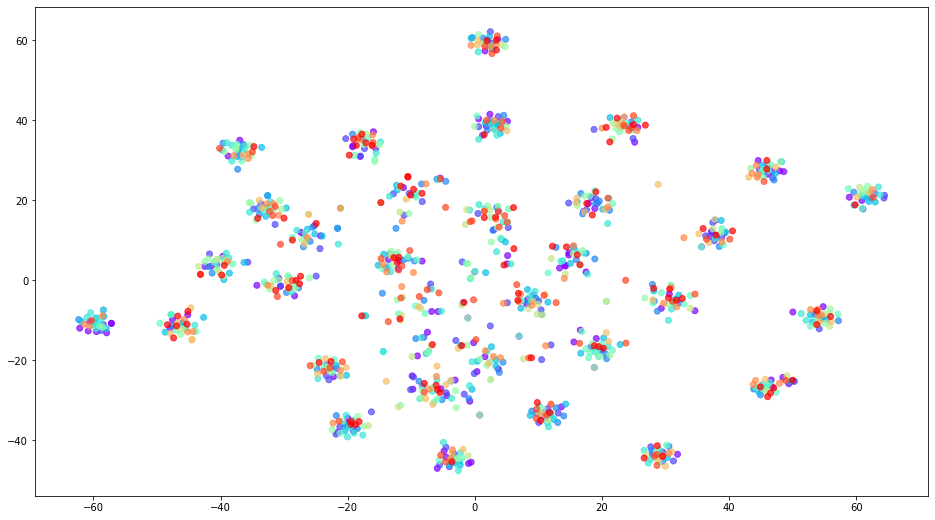

In [0]:
#assign different color based on month
embeddings = [[],[],[],[],[],[],[],[],[],[],[],[]]
temp = [[],[],[],[],[],[],[],[],[],[],[],[]]
for want,use in zip(embeddings_2d,sum(exemplar_indices, [])):
  month_t = time_onlymonth[use]-1
  # print (star)
  # print(y[use])
  temp[month_t].append(want.tolist())
for i in range(12):
  embeddings[i] = np.array(temp[i])


tsne_plot(embeddings, 0.7)


**Quick insights for 1.3.1:** comparing with the previous one. It's obvious that the distribution is even more random. Maybe what customer comment about is less revlavent with month

### Step 1.3.2 Week
but, what about I look at the comment that's based on weekly basis

In [0]:
#pull out the month of each rating
time_onlwk=[]
week_let=""
for item in converted_times:
    week_let= item.strftime("%A")
    if week_let=="Monday":
      week_num=1
    elif week_let=="Tuesday":
      week_num=2
    elif week_let=="Wednesday":
      week_num=3
    elif week_let=="Thursday":
      week_num=4
    elif week_let=="Friday":
      week_num=5
    elif week_let=="Saturday":
      week_num=6
    elif week_let=="Sunday":
      week_num=7

    time_onlwk.append(week_num)
    # time_onlymonth=np.asarray(time_onlym)
    # print (time_onlymonth)


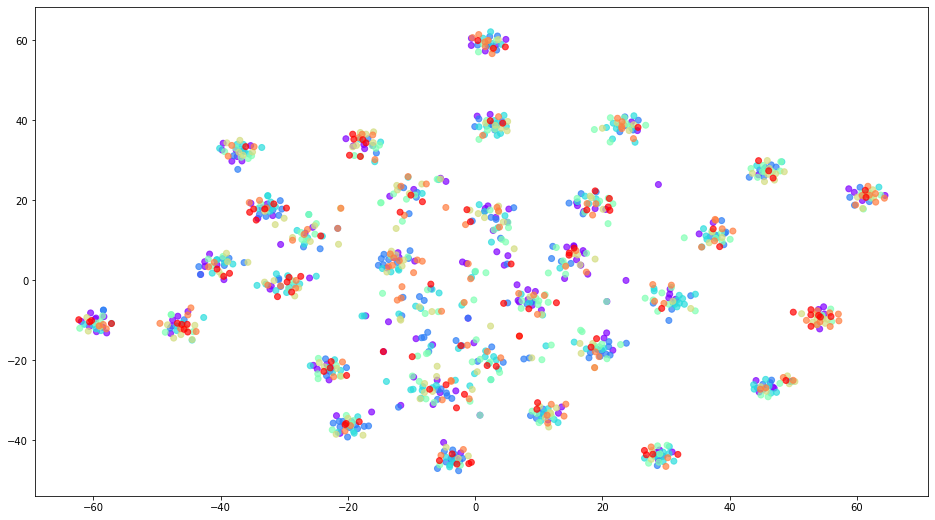

In [0]:
embeddings = [[],[],[],[],[],[],[]]
temp = [[],[],[],[],[],[],[]]
for want,use in zip(embeddings_2d,sum(exemplar_indices, [])):
  week_t = time_onlwk[use]-1
  temp[week_t].append(want.tolist())
for i in range(7):
  embeddings[i] = np.array(temp[i])

tsne_plot(embeddings, 0.7)

**Quick insight for 1.3.2:** Seems cluster have no obvious relation to weekday, and I think we can move away from this model, and say there is less time parameter contributed to the clustering

#Step 2: Learning From Time


It might make sense to learn the raw data first, what I'm doing below is looking at time and number of different rating

##Step 2.1 function

In [0]:
#Convert time into desired form
time_test = convert_times(reviews_times)

In [0]:
#get rating from HW4
star1 = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
star = np.repeat(star1, 5)

In [0]:
#take rating dataset, time dataset, defining form of date as input
def time_rating(rating,time,time_form):
  #below the function is to correspond each review and its date
  time_matrix = []

  #the time form is y-m-d
  for item in time_test:
      time_matrix.append(item.strftime(time_form))#"%Y-%m-%d"

  time_x= list(dict.fromkeys(time_matrix))
  time_x.sort()

  Rating_y = np.zeros((len(time_x),5))
  s_ym_yy = np.zeros((len(time_x),5))

  # put rating into its date
  for ym,item in zip(time_matrix,rating):
      for i in range(len(Rating_y)):
          if ym == time_x[i]:
              Rating_y[i][item-1] +=1
  return time_x,Rating_y


In [0]:
# I want to see how many of each review every day,i is which rating you want to check
def countrating(i,Rating_y):
  count_star = []
  count_total = []
  count_roll = []
  count_total_log = []
  for item in Rating_y:
      count_star.append(item[i-1])
      # count_total.append(np.sum(item))
      # count_total_log.append(math.log(np.sum(item)))
  star_total = pd.Series(count_star)
  star_count_roll = star_total.rolling(window=12,center=False).mean()
  return count_star,star_count_roll

In [0]:
#convert time to y-m-d form
ym_xx,ym_yy=time_rating(star,time_test,"%Y-%m-%d")

In [0]:
#count each rating
count_1,one_star_count_roll=countrating(1,ym_yy)
count_2,two_star_count_roll=countrating(2,ym_yy)
count_3,three_star_count_roll=countrating(3,ym_yy)
count_4,four_star_count_roll=countrating(4,ym_yy)
count_5,five_star_count_roll=countrating(5,ym_yy)

## Step 2.2 Count Time
Let's figure out what happend in each rating's trend

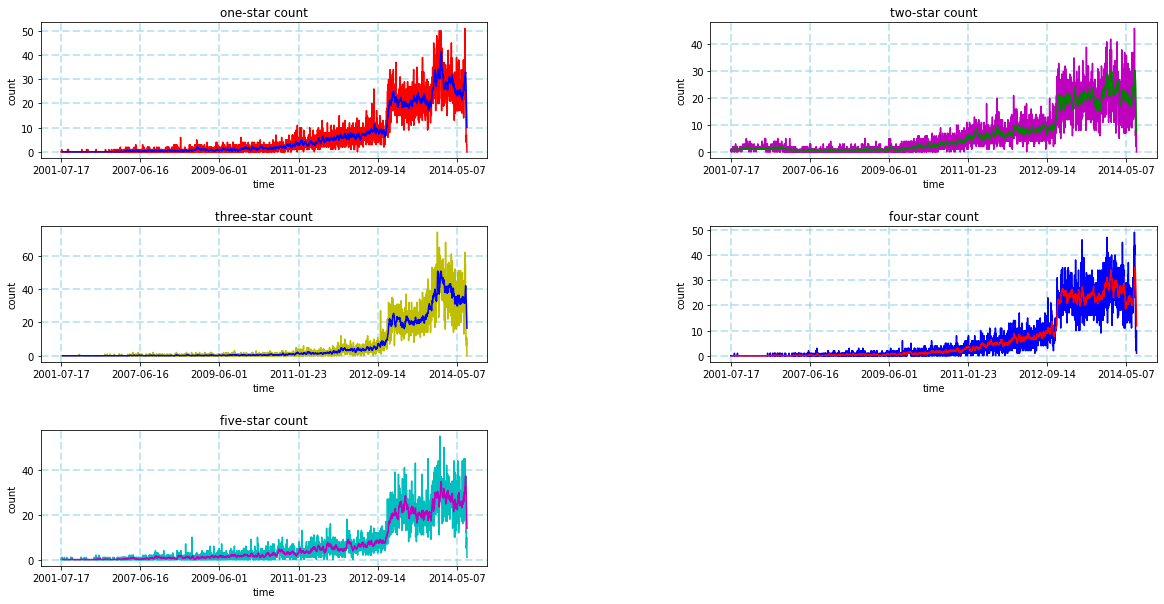

In [136]:
plt.figure(figsize=(20,10))
xmajorLocator   = MultipleLocator(600)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

#1 star count
one_star=plt.subplot(321)
one_star.set_title('one-star count')           
one_star.set_xlabel('time')                
one_star.set_ylabel('count')
one_star.xaxis.set_major_locator(xmajorLocator)
one_star.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
plt.plot(ym_xx,count_1,'r',#one-star
         ym_xx,one_star_count_roll,"b"
         )

#2 star count
two_star=plt.subplot(322)
two_star.set_title('two-star count')           
two_star.set_xlabel('time')                
two_star.set_ylabel('count')
two_star.xaxis.set_major_locator(xmajorLocator)
two_star.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
plt.plot(ym_xx,count_2,'m',#two-star
         ym_xx,two_star_count_roll,"g"
         )


#3 star count
three_star=plt.subplot(323)
three_star.set_title('three-star count')           
three_star.set_xlabel('time')                
three_star.set_ylabel('count')
three_star.xaxis.set_major_locator(xmajorLocator)
three_star.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
plt.plot(ym_xx,count_3,'y',#3-star
         ym_xx,three_star_count_roll,"b"
         )

#4 star count
four_star=plt.subplot(324)
four_star.set_title('four-star count')           
four_star.set_xlabel('time')                
four_star.set_ylabel('count')
four_star.xaxis.set_major_locator(xmajorLocator)
xmajorLocator   = MultipleLocator(400)
four_star.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
plt.plot(ym_xx,count_4,'b',#4-star
         ym_xx,four_star_count_roll,"r"
         )

#5star count
five_star=plt.subplot(325)
five_star.set_title('five-star count')           
five_star.set_xlabel('time')                
five_star.set_ylabel('count')
xmajorLocator_5   = MultipleLocator(600)
five_star.xaxis.set_major_locator(xmajorLocator_5)
five_star.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
plt.plot(ym_xx,count_5,'c',#five-star
         ym_xx,five_star_count_roll,"m"
         )
plt.show()


**Quick Insights fir 1.3.2** rating count seems to have visual similarity, but not very clear. In order to have better understanding of its trend, I have incorporated the mean of each rating count into one picture 

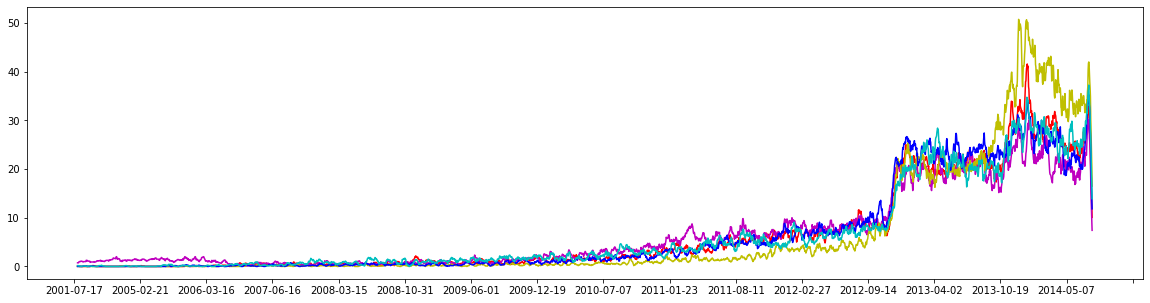

In [137]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111)
xmajorLocator  = MultipleLocator(200)
ax.xaxis.set_major_locator(xmajorLocator)
plt.plot(ym_xx,one_star_count_roll,"r",
         ym_xx,two_star_count_roll,"m",
         ym_xx,three_star_count_roll,"y",
         ym_xx,four_star_count_roll,"b",
         ym_xx,five_star_count_roll,"c"
         )

**Quick Insight for Step 2:** counts of 5 rating share features:

1. They both exprienced increasing four times,3 drops proximately at same time period
In terms of whole picture, the trend increasing
2. they both slowly increased  2009-12-19 to 2012-09-14
3. They both drastically increased at the time between 2012-09-14
5. After  the second increase, five ratings both fluctuate 20-30 per day

Amount of 5 ratings have very similar pattern. Let's figure the possible model for 5 stars rating




# Step 3: Possible Trend in Daily Rating Count

## Step 3.1 Selecting Data
By observing the data. We can clearly see how the early data is statistically different from the latest one, and we can see Amazon review is periodically expereice cycle of "platau-increase", and the platau approximately equals 6 months. 

Also, there is significantally wierd drop at the end of data. This might be caused by that the data hasn't uptated in time when collecting. So we should also remove it

In [0]:
#take rating dataset, time dataset, defining form of date as input
def time_rating_new(rating,time,time_form):
  #below the function is to correspond each review and its date
  time_matrix = []
  rating_l=[]
  for item,stars in zip(time_test,rating):
      if item.strftime("%Y-%m-%d") >= "2012-01-01" and item.strftime("%Y-%m-%d") < "2014-07-01":
          time_matrix.append(item.strftime("%Y-%m-%d"))
          rating_l.append(stars)

  time_x= list(dict.fromkeys(time_matrix))
  time_x.sort()

  Rating_y = np.zeros((len(time_x),5))
  s_ym_yy = np.zeros((len(time_x),5))

  # put rating into its date
  for ym,item in zip(time_matrix,rating_l):
      for i in range(len(Rating_y)):
          if ym == time_x[i]:
              Rating_y[i][item-1] +=1
  return time_x,Rating_y


In [0]:
#implement function to calculate 5 star per day
x_time,y_rating=time_rating_new(star,time_test,"%Y-%m-%d")
five_count,five_roll=countrating(5,y_rating)
five_count_s=pd.Series(five_count)

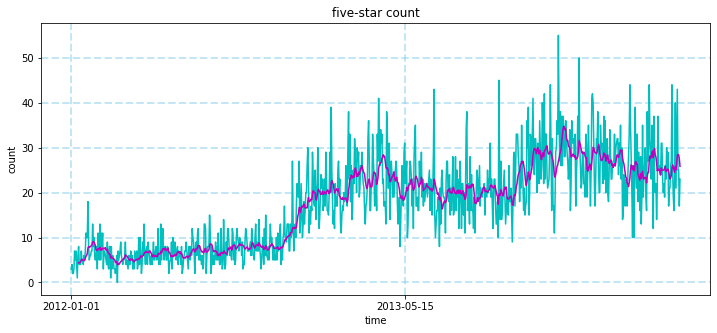

In [140]:
#5 star count
plt.figure(figsize=(30,20))
xmajorLocator   = MultipleLocator(500)
plt.subplots_adjust(wspace=0.5, hspace=0.5)

five_star=plt.subplot(325)
five_star.set_title('five-star count')           
five_star.set_xlabel('time')                
five_star.set_ylabel('count')
five_star.xaxis.set_major_locator(xmajorLocator)
five_star.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

plt.plot(x_time,five_count,'c',#five-star
         x_time,five_roll,"m"
         )
plt.show()

## Step 3.2: Make Data Stationary

In [0]:
# Check stationarity 
def test_stationality_new_1(ts):

  plt.figure(figsize=(30,8))
  xmajorLocator   = MultipleLocator(200)
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  hw4_av_dia=plt.subplot(121)
  hw4_av_dia.set_title('five star count')           
  hw4_av_dia.set_xlabel('time')                
  hw4_av_dia.set_ylabel('count')
  hw4_av_dia.xaxis.set_major_locator(xmajorLocator)
  hw4_av_dia.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

  ts_s = pd.Series(ts)
  
  score_roll = ts_s.rolling(window=12,center=False).mean().tolist()
  std_roll = ts_s.rolling(window=12,center=False).std().tolist()
  ts_s_1 = ts_s.dropna()
  #plotstuff
  plt.plot(x_time,ts,"b",
           x_time,score_roll,"r",
           x_time,std_roll,"black"
          )

  print('Results of Dickey-Fuller Test:')
  # ts_s=pd.Series(ts)
  dftest = adfuller(ts_s_1,autolag= 'AIC')
  # dftest = adfuller(hw4_avg_s.fittedvalues,autolag= 'AIC')
  dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value(%s)'%key] = value
  print(dfoutput)

  plt.show(block=False)

Results of Dickey-Fuller Test:
Test Statistic                  -1.275723
p-value                          0.640205
#Lags Used                      20.000000
Number of Observations Used    891.000000
Critical Value(1%)              -3.437711
Critical Value(5%)              -2.864789
Critical Value(10%)             -2.568500
dtype: float64


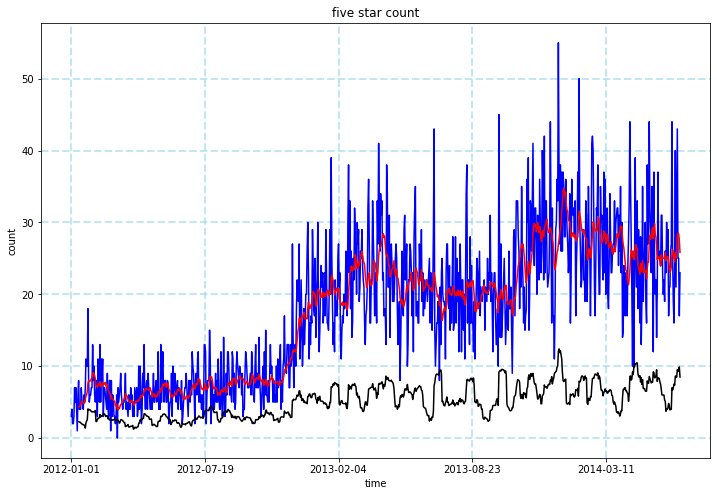

In [142]:
five_ori_dft= test_stationality_new_1(five_count_s)

**Quick Summary:** the p value is greater than 0.1, we should difference it to make it stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.247333e+01
p-value                        3.208673e-23
#Lags Used                     1.900000e+01
Number of Observations Used    8.910000e+02
Critical Value(1%)            -3.437711e+00
Critical Value(5%)            -2.864789e+00
Critical Value(10%)           -2.568500e+00
dtype: float64


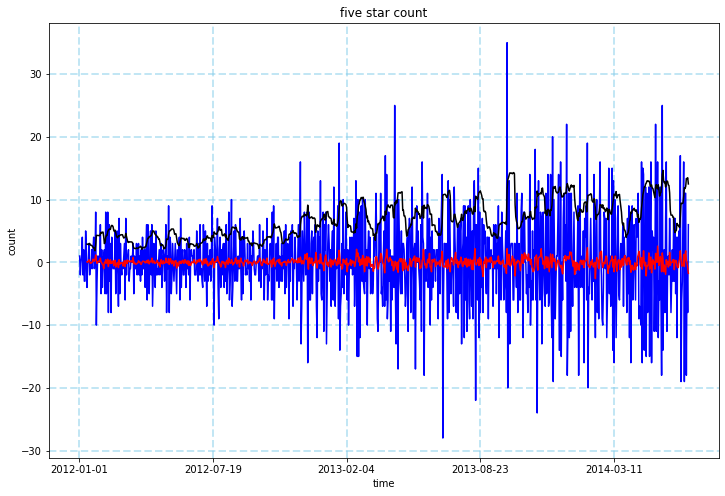

In [143]:
# Differencing
five_diff=five_count_s.diff(1)
test_stationality_new_1(five_diff)

# Step 3.3 Implementing Model
In this section, I'm gonna apply data into AR/MA/ARIM to predict

In [0]:
# function
def armodel(x,p,d,q):
  model = ARIMA(x,order = (p,d,q))
  result = model.fit(disp = -1)
  return result

## Step 3.3.1 AR Model

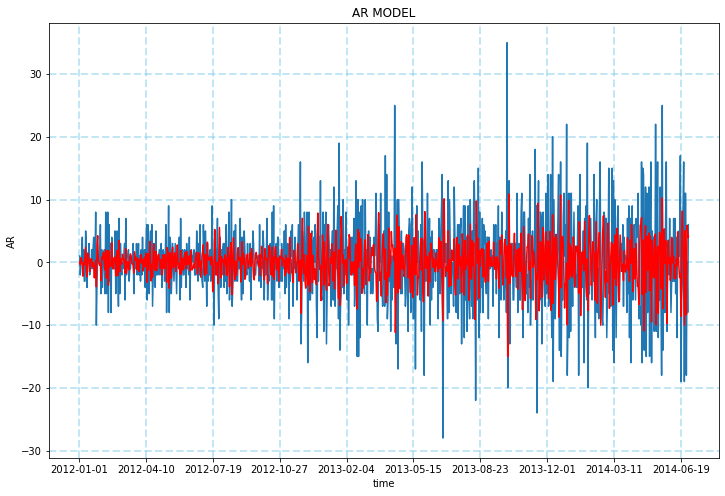

In [145]:
#AR model

five_results_AR=armodel(five_count_s,2,1,0)
plt.figure(figsize=(30,8))
xmajorLocator   = MultipleLocator(100)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
diam=plt.subplot(121)
diam.set_title('AR MODEL')           
diam.set_xlabel('time')                
diam.set_ylabel('AR')
diam.xaxis.set_major_locator(xmajorLocator)
diam.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

plt.plot(x_time,five_diff)
plt.plot(five_results_AR.fittedvalues,color = 'red')

plt.show()

## Step 3.3.2 MA model

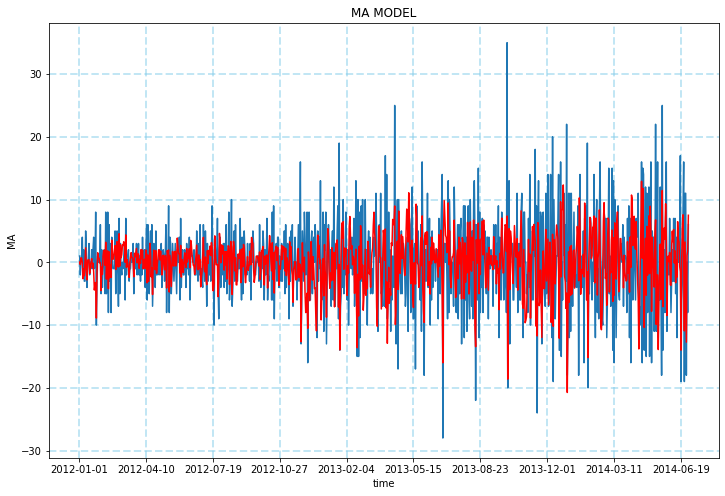

In [146]:
# MA model
five_results_MA=armodel(five_count_s,0,1,2)
plt.figure(figsize=(30,8))
xmajorLocator   = MultipleLocator(100)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
diam=plt.subplot(121)
diam.set_title('MA MODEL')           
diam.set_xlabel('time')                
diam.set_ylabel('MA')
diam.xaxis.set_major_locator(xmajorLocator)
diam.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

plt.plot(x_time,five_diff)
plt.plot(five_results_MA.fittedvalues,color = 'red')

plt.show()

## Step 3.3.2 ARIMA Model

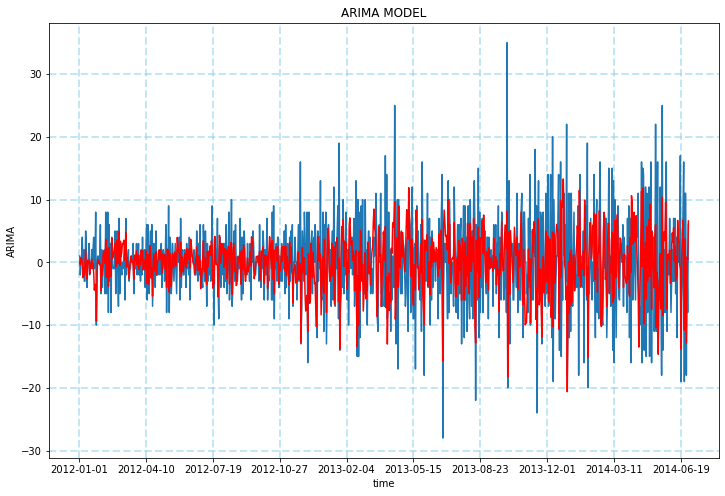

In [147]:
# ARIMA model
five_results_ARIMA=armodel(five_count_s,3,1,2)
plt.figure(figsize=(30,8))
xmajorLocator   = MultipleLocator(100)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
diam=plt.subplot(121)
diam.set_title('ARIMA MODEL')           
diam.set_xlabel('time')                
diam.set_ylabel('ARIMA')
diam.xaxis.set_major_locator(xmajorLocator)
diam.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

plt.plot(x_time,five_diff)
plt.plot(five_results_ARIMA.fittedvalues,color = 'red')

plt.show()

## Step 3.4: Prediction
translate back to orginal scale 

In [0]:
#Function for last step transform data back to original
def backtoOrigin_amount(result):
  pd_AR_diff = pd.Series(result.fittedvalues,copy = True)
  pd_AR_diff_cumsum = pd_AR_diff.cumsum()
  pd_AR= pd.Series(av_log_s.ix[0],index = av_log_s.index)
  pd_AR= pd_AR_log.add(pd_AR_diff_cumsum, fill_value = 0)
  # prediction = np.exp(pd_AR_log)
  prediction = pd_AR
  return prediction

In [0]:
def armodel(x,p,d,q):
  model = ARIMA(x,order = (p,d,q))
  result = model.fit(disp = -1)
  return result

In [0]:
#back to original five
def backtoOrigin_amount(result):
  pd_AR_diff = pd.Series(result.fittedvalues,copy = True)
  pd_AR_diff_cumsum = pd_AR_diff.cumsum()
  pd_AR_1= pd.Series(five_count_s.ix[0],index = five_count_s.index)
  pd_AR= pd_AR_1.add(pd_AR_diff_cumsum, fill_value = 0)
  # prediction = np.exp(pd_AR_log)
  prediction = pd_AR
  return prediction

I'm putting all the result from different models and compare with the original one. RMSE help me with selecting the best model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


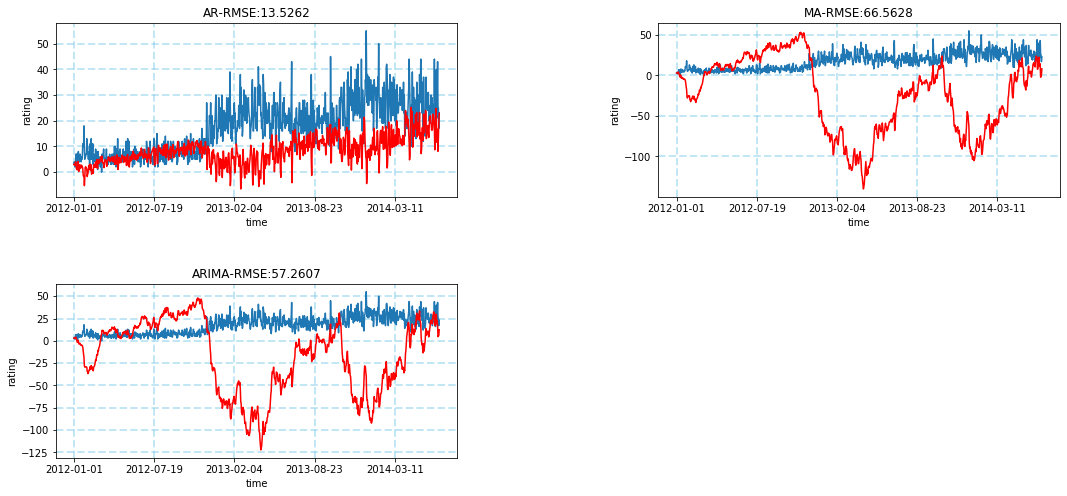

In [151]:
plt.figure(figsize=(18,8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#AR
predictionAR_five=backtoOrigin_amount(five_results_AR)
xmajorLocator   = MultipleLocator(200)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
AR_diagram=plt.subplot(221)          
AR_diagram.set_xlabel('time')                
AR_diagram.set_ylabel('rating')
AR_diagram.xaxis.set_major_locator(xmajorLocator)
AR_diagram.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
AR_diagram.set_title('AR-RMSE:%.4f'% np.sqrt(sum((predictionAR_five-five_count_s)**2)/len(five_count_s)))
plt.plot(x_time,five_count_s)
plt.plot(predictionAR_five,'r')

#MA
predictionMA_five=backtoOrigin_amount(five_results_MA)
xmajorLocator   = MultipleLocator(200)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
AR_diagram=plt.subplot(222)          
AR_diagram.set_xlabel('time')                
AR_diagram.set_ylabel('rating')
AR_diagram.xaxis.set_major_locator(xmajorLocator)
AR_diagram.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
AR_diagram.set_title('MA-RMSE:%.4f'% np.sqrt(sum((predictionMA_five-five_count_s)**2)/len(five_count_s)))
plt.plot(x_time,five_count_s)
plt.plot(predictionMA_five,'r')


# ARIMA
predictionARIMA_five=backtoOrigin_amount(five_results_ARIMA)
xmajorLocator = MultipleLocator(200)

ARIMA_diagram=plt.subplot(223)          
ARIMA_diagram.set_xlabel('time')                
ARIMA_diagram.set_ylabel('rating')
ARIMA_diagram.xaxis.set_major_locator(xmajorLocator)
ARIMA_diagram.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
ARIMA_diagram.set_title('ARIMA-RMSE:%.4f'% np.sqrt(sum((predictionARIMA_five-five_count_s)**2)/len(five_count_s)))
plt.plot(x_time,five_count_s)
plt.plot(predictionARIMA_five,'r')


plt.show()

**Insigts for 3.3:** Prediction is red; blue is original. Even if AR seems have a better RMSE and better graphical match comparing with ARMA and MA, but the RMSE is still to big and the red line is visiblly different from original one. 

There some reason might cause the problem:


1.   Unsuccessful scaling down data
2.   Overfitting




# Step 4: Look at whole picture
In Step 3, I've selected small part of dataset, but keep complex details; It might be interesting to do another way around: Look at whole dataset, but take the "month" as unit.
Instead of count number of each rating. I did average rating for this section

## Step 4.1: Function

In [0]:
def averageRating(rating,time,time_form):
  #below the function is to correspond each review and its date
  time_matrix = []

  #the time form is y-m-d
  for item in time_test:
    
      time_item=item.strftime(time_form)
      time_matrix.append(time_item)#"%Y-%m-%d"

  time_x= list(dict.fromkeys(time_matrix))
  time_x.sort()

  Rating_y = np.zeros((len(time_x),5))
  temp = np.zeros((len(time_x),5))

  # put rating into its date
  for ym,item in zip(time_matrix,rating):
      for i in range(len(Rating_y)):
          if ym == time_x[i]:
              Rating_y[i][item-1] +=1


  # get rate for each rating    
  for item,num in zip(Rating_y,temp):
      for i in range(5):
          num[i] = item[i]/np.sum(item)
  star_1 = []
  star_2 = []
  star_3 = []
  star_4 = []
  star_5 = []
  av_star = []
  count_roll=[]

  for i in range(len(Rating_y)):
      star_1.append(temp[i][0])
      star_2.append(temp[i][1])
      star_3.append(temp[i][2])
      star_4.append(temp[i][3])
      star_5.append(temp[i][4])

  for a,b,c,d,e in zip(star_1,star_2,star_3,star_4,star_5):
      av_star.append(1*a+2*b+3*c+4*d+5*e)

  # roll_std=pd.rolling(total_pd, 4,center = True).std()
  return time_x,av_star


In [0]:
av_x_time,hw4_av_star=averageRating(star,time_test,"%Y-%m")

In [0]:
#perform Dickey-Fuller
def test_stationality(ts):

  plt.figure(figsize=(30,8))
  xmajorLocator   = MultipleLocator(30)
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  hw4_av_dia=plt.subplot(121)
  hw4_av_dia.set_title('average rating')           
  hw4_av_dia.set_xlabel('time')                
  hw4_av_dia.set_ylabel('rating')
  hw4_av_dia.xaxis.set_major_locator(xmajorLocator)
  hw4_av_dia.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

  ts_s_1 = pd.Series(ts)
  ts_s=ts_s_1.dropna()
  score_roll = ts_s.rolling(window=12,center=False).mean().tolist()
  std_roll = ts_s.rolling(window=12,center=False).std().tolist()
  #plotstuff
  plt.plot(av_x_time,ts,"b",
           av_x_time,score_roll,"r",
           av_x_time,std_roll,"black"
          )

  print('Results of Dickey-Fuller Test:')
  # ts_s=pd.Series(ts)
  dftest = adfuller(ts_s,autolag= 'AIC')
  # dftest = adfuller(hw4_avg_s.fittedvalues,autolag= 'AIC')
  dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value(%s)'%key] = value
  print(dfoutput)

  plt.show(block=False)

## Step 4.2 Stationarity test for average ratting

Results of Dickey-Fuller Test:
Test Statistic                  -0.697201
p-value                          0.847473
#Lags Used                      11.000000
Number of Observations Used    139.000000
Critical Value(1%)              -3.478294
Critical Value(5%)              -2.882568
Critical Value(10%)             -2.577983
dtype: float64


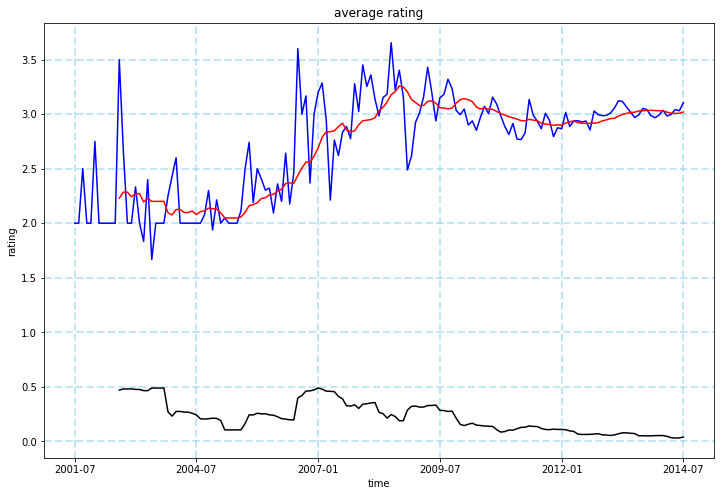

In [155]:
test_stationality(hw4_av_star)
hw4_av_star_s=pd.Series(hw4_av_star)

**Summary for Step 4.2:** the p-value is breater than 1%
We cannot reject the null hypothesis (non-stationarity), the rolling mean indicates a increasing trend

## Step 4.3: Make Data More Stationary
Below I'm trying different way to make data more stationary

### Step 4.3.1: Differencing through Log

Results of Dickey-Fuller Test:
Test Statistic                  -1.005549
p-value                          0.751235
#Lags Used                      13.000000
Number of Observations Used    137.000000
Critical Value(1%)              -3.479007
Critical Value(5%)              -2.882878
Critical Value(10%)             -2.578149
dtype: float64


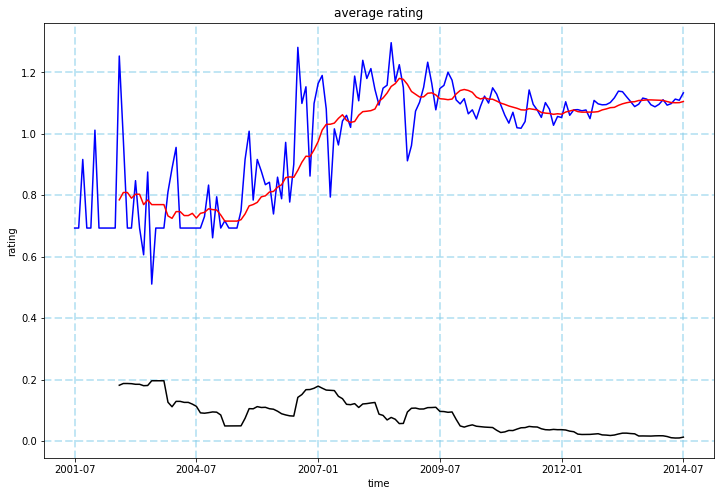

In [156]:
# av_log=math.log(hw4_av_star)
av_log=[]
for item in hw4_av_star:
  av_log.append(math.log(item))

test_stationality(av_log)

**Quick insights for Step 4.3.1:** P value gets down, but this still suggests that the log series is not stationary

### Step 4.3.2: Differencing through Moving Average

In [0]:
#perform Dickey-Fuller
def test_stationality_new(ts):

  plt.figure(figsize=(30,8))
  xmajorLocator   = MultipleLocator(30)
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  hw4_av_dia=plt.subplot(121)
  hw4_av_dia.set_title('average rating')           
  hw4_av_dia.set_xlabel('time')                
  hw4_av_dia.set_ylabel('rating')
  hw4_av_dia.xaxis.set_major_locator(xmajorLocator)
  hw4_av_dia.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

  ts_s = pd.Series(ts)
  
  score_roll = ts_s.rolling(window=12,center=False).mean().tolist()
  std_roll = ts_s.rolling(window=12,center=False).std().tolist()
  ts_s_1 = ts_s.dropna()
  #plotstuff
  plt.plot(av_x_time,ts,"b",
           av_x_time,score_roll,"r",
           av_x_time,std_roll,"black"
          )

  print('Results of Dickey-Fuller Test:')
  # ts_s=pd.Series(ts)
  dftest = adfuller(ts_s_1,autolag= 'AIC')
  # dftest = adfuller(hw4_avg_s.fittedvalues,autolag= 'AIC')
  dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value(%s)'%key] = value
  print(dfoutput)

  plt.show(block=False)

Results of Dickey-Fuller Test:
Test Statistic                  -4.427528
p-value                          0.000265
#Lags Used                      12.000000
Number of Observations Used    137.000000
Critical Value(1%)              -3.479007
Critical Value(5%)              -2.882878
Critical Value(10%)             -2.578149
dtype: float64


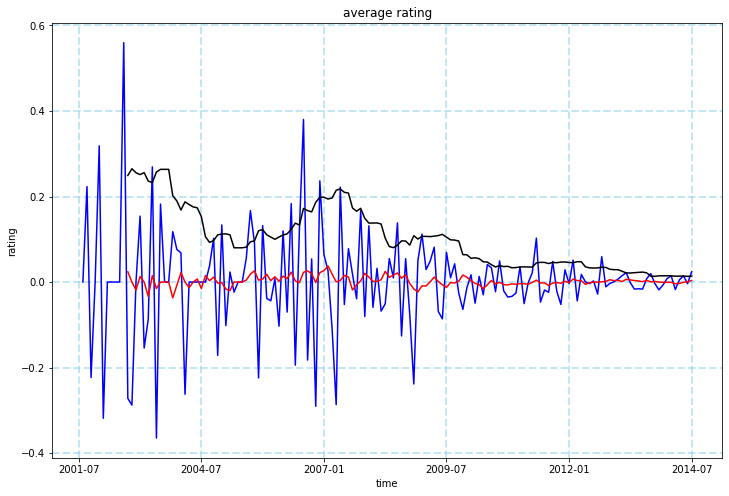

In [158]:
av_log_s=pd.Series(av_log)
avg_log_diff=av_log_s.diff(1)
test_stationality_new(avg_log_diff)

**Summary 4.3:** After moving average, the data seems to be stationary

## Step 4.4: Making Prediction

### Step 4.4.1 AR Model

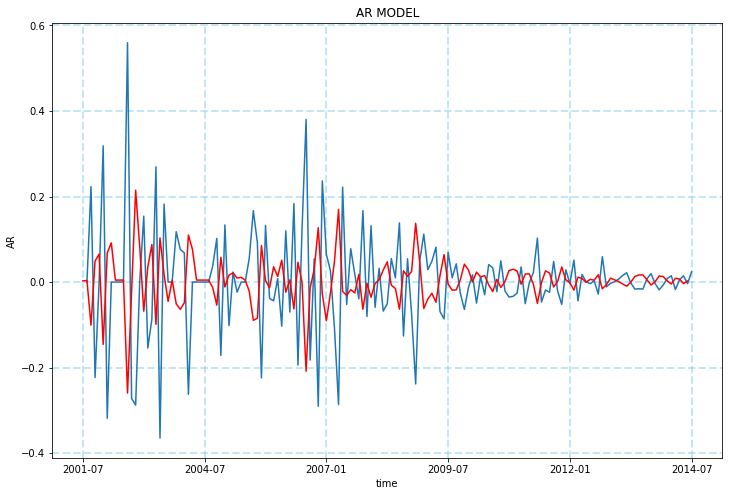

In [159]:
#AR model

results_AR=armodel(av_log,2,1,0)
plt.figure(figsize=(30,8))
xmajorLocator   = MultipleLocator(30)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
diam=plt.subplot(121)
diam.set_title('AR MODEL')           
diam.set_xlabel('time')                
diam.set_ylabel('AR')
diam.xaxis.set_major_locator(xmajorLocator)
diam.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

plt.plot(av_x_time,avg_log_diff)
plt.plot(results_AR.fittedvalues,color = 'red')

plt.show()

### Step 4.4.2 MA Model

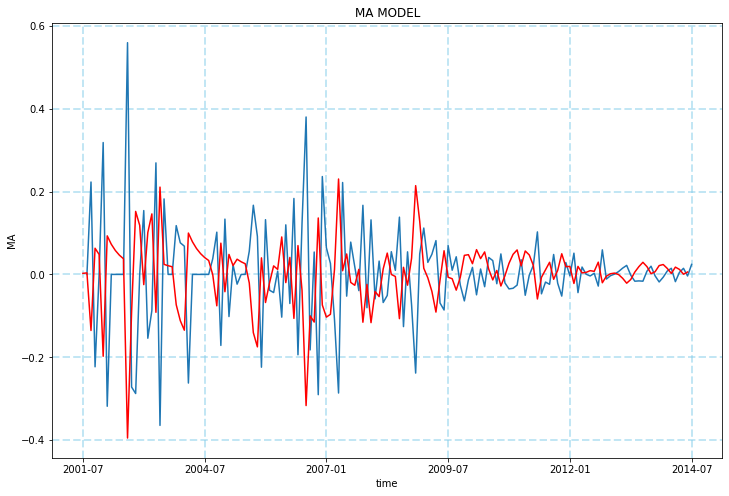

In [160]:
# MA model
results_MA=armodel(av_log,0,1,1)
plt.figure(figsize=(30,8))
xmajorLocator   = MultipleLocator(30)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
diam=plt.subplot(121)
diam.set_title('MA MODEL')           
diam.set_xlabel('time')                
diam.set_ylabel('MA')
diam.xaxis.set_major_locator(xmajorLocator)
diam.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

plt.plot(av_x_time,avg_log_diff)
plt.plot(results_MA.fittedvalues,color = 'red')

plt.show()

### Step 4.4.3 ARIMA Model

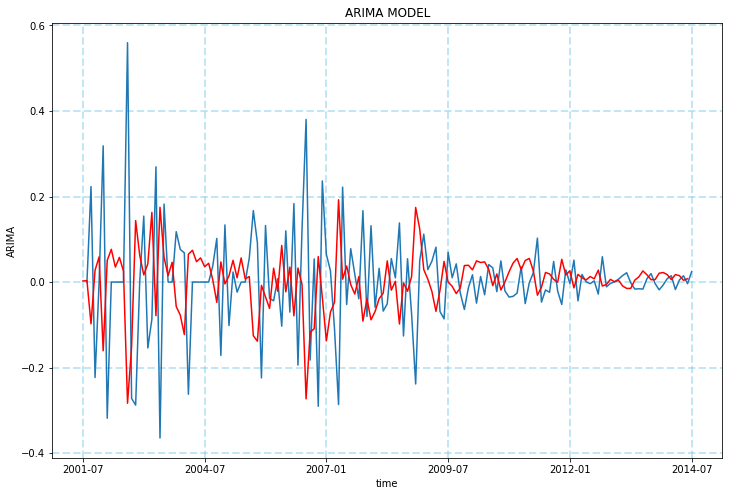

In [161]:
# ARIMA model
results_ARIMA=armodel(av_log,2,1,2)
plt.figure(figsize=(30,8))
xmajorLocator   = MultipleLocator(30)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
diam=plt.subplot(121)
diam.set_title('ARIMA MODEL')           
diam.set_xlabel('time')                
diam.set_ylabel('ARIMA')
diam.xaxis.set_major_locator(xmajorLocator)
diam.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)

plt.plot(av_x_time,avg_log_diff)
plt.plot(results_ARIMA.fittedvalues,color = 'red')

plt.show()

## Step 4.5: Prediction

transform back to orginal 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


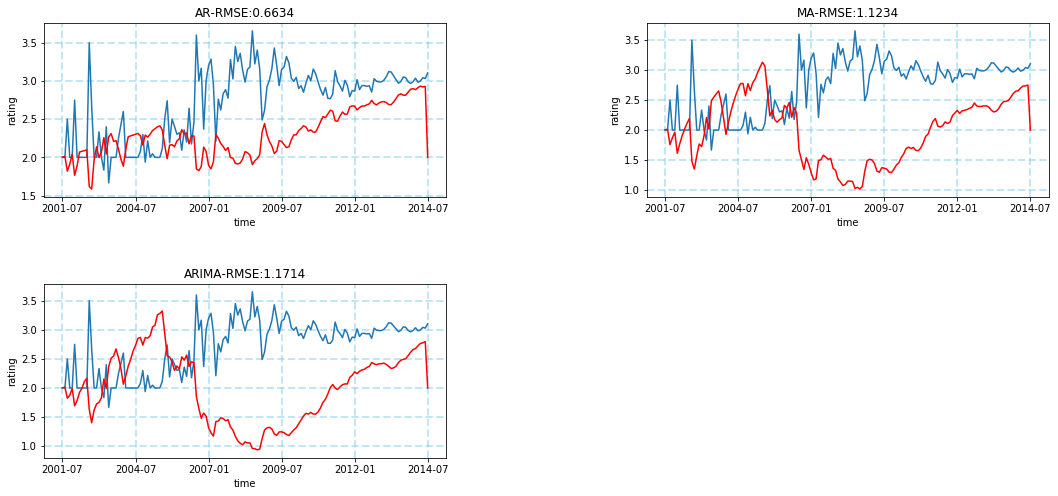

In [162]:
plt.figure(figsize=(18,8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

#AR
predictionAR=backtoOrigin(results_AR)
xmajorLocator   = MultipleLocator(30)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
AR_diagram=plt.subplot(221)          
AR_diagram.set_xlabel('time')                
AR_diagram.set_ylabel('rating')
AR_diagram.xaxis.set_major_locator(xmajorLocator)
AR_diagram.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
AR_diagram.set_title('AR-RMSE:%.4f'% np.sqrt(sum((predictionAR-hw4_av_star_s)**2)/len(hw4_av_star_s)))
plt.plot(av_x_time,hw4_av_star_s)
plt.plot(predictionAR,'r')

#MA
predictionMA=backtoOrigin(results_MA)
xmajorLocator   = MultipleLocator(30)
MA_diagram=plt.subplot(222)          
MA_diagram.set_xlabel('time')                
MA_diagram.set_ylabel('rating')
MA_diagram.set_title('MA-RMSE:%.4f'% np.sqrt(sum((predictionMA-hw4_av_star_s)**2)/len(hw4_av_star_s)))
MA_diagram.xaxis.set_major_locator(xmajorLocator)
MA_diagram.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
plt.plot(av_x_time,hw4_av_star_s)
plt.plot(predictionMA,'r')



# ARIMA
predictionARIMA=backtoOrigin(results_ARIMA)
xmajorLocator = MultipleLocator(30)

ARIMA_diagram=plt.subplot(223)          
ARIMA_diagram.set_xlabel('time')                
ARIMA_diagram.set_ylabel('rating')
ARIMA_diagram.xaxis.set_major_locator(xmajorLocator)
ARIMA_diagram.grid(b=True,which='major',axis='both',alpha= 0.5,color='skyblue',linestyle='--',linewidth=2)
ARIMA_diagram.set_title('ARIMA-RMSE:%.4f'% np.sqrt(sum((predictionARIMA-hw4_av_star_s)**2)/len(hw4_av_star_s)))
plt.plot(av_x_time,hw4_av_star_s)
plt.plot(predictionARIMA,'r')


plt.show()

# **Step 5: Insights** 
In general, from perspective of RMSE, AR model works better. Problem still exisit: None of then graphically match. There is still a good amount of space to improve model to predict.

1. Chooding data is still critical. Should we keep the old data, if the review system have once changed?
2.   Context does really matter in reality. I was introducing out side data, finding that the rating from different category have very interesting feature (e.g Electronics product's peak  rating count is less obvious than the dataset provided in HW4 

